In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

Matplotlib is building the font cache; this may take a moment.


In [54]:
df = pd.read_csv("/Users/jk/Downloads/Normalized_GSE108474_expression_data_with_ID.csv") 


In [56]:
numeric_df = df.select_dtypes(include=['number'])  # Select numeric columns only
corr_matrix = numeric_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]
df_reduced = df.drop(columns=high_corr_features)  # Drop from original df
print(f"Removed {len(high_corr_features)} redundant features.")

Removed 468 redundant features.


In [58]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Select numeric columns only and create a copy
numeric_cols = df_reduced.select_dtypes(include=['number']).columns
X_scaled_data = df_reduced[numeric_cols].copy()

# Convert columns to numeric explicitly
X_scaled_data = X_scaled_data.apply(pd.to_numeric, errors='coerce')

# ----> Drop columns where ALL values are NaN
X_scaled_data = X_scaled_data.dropna(axis=1, how='all')

# ----> Impute NaN values before scaling (only columns with some valid values remain)
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with column mean
X_imputed = imputer.fit_transform(X_scaled_data)

# ----> Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)



In [60]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

pca = PCA(n_components=2)  # Extract the first 2 principal components
# Changed 'scaled_data' to 'X_scaled'
principal_components = pca.fit_transform(X_scaled) 

# Create a DataFrame for PC1 and PC2
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print(pca_df.head()) 

        PC1       PC2
0  4.278977 -0.305206
1  5.639071 -0.362798
2  1.670631 -0.386710
3  9.190225 -0.392358
4  9.305242 -0.498301


In [62]:
cov_matrix = np.cov(X_scaled.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [64]:
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

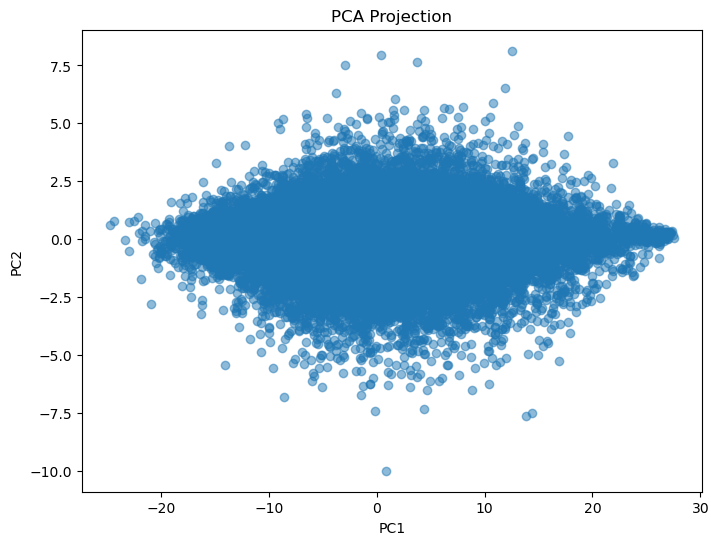

In [66]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection')
plt.show()


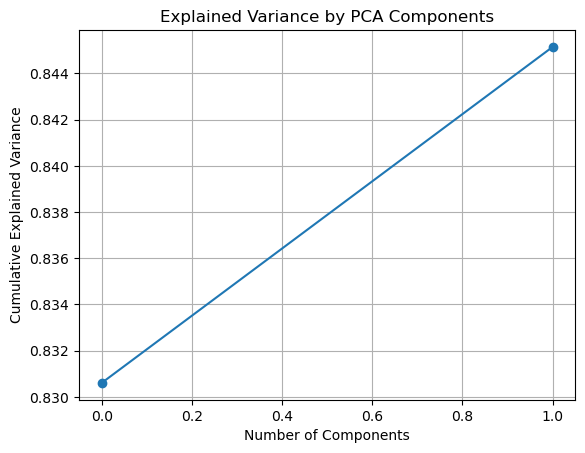

In [68]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()


In [74]:
import numpy as np
import pandas as pd
df = pd.read_csv("//Users/jk/Downloads/Normalized_GSE108474_expression_data_with_ID.csv") 
df.to_csv("/Users/jk/Downloads/cleaned_normalized_gse108474_data.csv")
print("success")

success


Original dataset shape (rows, columns): (54613, 543)
Missing values in the dataset:
Unnamed: 0    0
id            0
GSM2899178    0
GSM2899179    0
GSM2899180    0
             ..
GSM2899714    0
GSM2899715    0
GSM2899716    0
GSM2899717    0
GSM2899718    0
Length: 543, dtype: int64
Numeric columns in the dataset: Index(['Unnamed: 0', 'GSM2899178', 'GSM2899179', 'GSM2899180', 'GSM2899181',
       'GSM2899182', 'GSM2899183', 'GSM2899184', 'GSM2899185', 'GSM2899186',
       ...
       'GSM2899709', 'GSM2899710', 'GSM2899711', 'GSM2899712', 'GSM2899713',
       'GSM2899714', 'GSM2899715', 'GSM2899716', 'GSM2899717', 'GSM2899718'],
      dtype='object', length=542)
Numeric-only dataset shape (rows, columns): (54613, 542)
Are there any missing values after imputation? 0


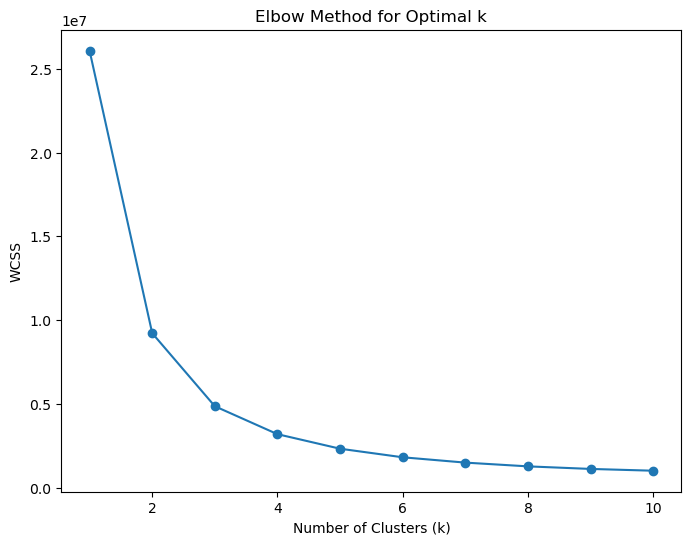

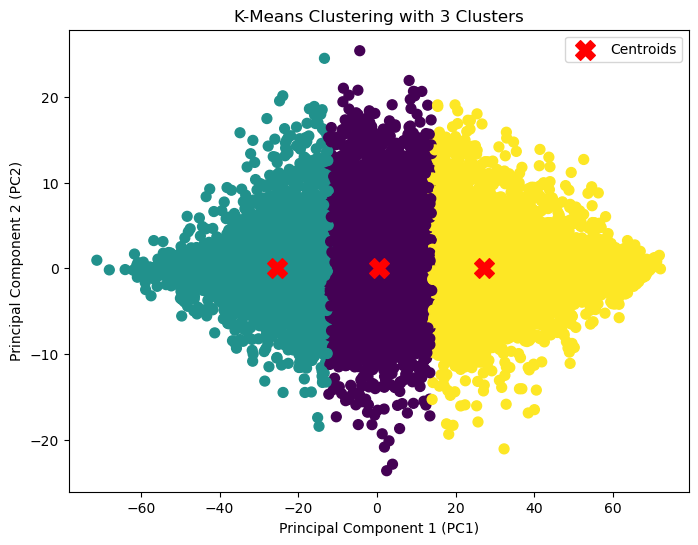

Centroids saved to 'kmeans_cluster_centroids.xlsx'
Number of points in each cluster: {0: 23884, 1: 16192, 2: 14537}


In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Step 1: Load dataset
file_path = "/Users/jk/Downloads/cleaned_normalized_gse108474_data.csv"
df = pd.read_csv(file_path)

# Step 2: Select numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Step 3: Handle missing values - Fill only numeric columns with column mean
imputer = SimpleImputer(strategy='mean')
df_filled_numeric = imputer.fit_transform(df_numeric)

# Step 4: Standardize the numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filled_numeric)

# Step 5: Re-impute if scaling introduced NaNs
if np.any(np.isnan(X_scaled)):
    X_scaled = imputer.fit_transform(X_scaled)

# Step 6: Apply PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 7: Elbow Method to find optimal number of clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 8: Fit final KMeans model
optimal_k = 3  # Adjust this based on elbow plot
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_optimal.fit(X_pca)

# Step 9: Visualize the clusters
cluster_labels = kmeans_optimal.labels_
cluster_centroids = kmeans_optimal.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=50, cmap='viridis')
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title(f"K-Means Clustering with {optimal_k} Clusters")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend()
plt.show()

# Step 10: Save centroids to Excel
centroids_df = pd.DataFrame(cluster_centroids, columns=['PC1', 'PC2'])
centroids_df.index.name = 'Cluster'
centroids_df.to_excel("kmeans_cluster_centroids.xlsx")

# Step 11: Report points per cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))


In [84]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np

# Bisecting K-Means implementation
def bisecting_kmeans(X, target_clusters):
    n_samples = X.shape[0]
    labels = np.zeros(n_samples, dtype=int)
    clusters = [np.arange(n_samples)]
    current_label = 1

    while len(clusters) < target_clusters:
        sizes = [len(c) for c in clusters]
        idx_to_split = np.argmax(sizes)
        cluster_to_split = clusters.pop(idx_to_split).astype(int)

        kmeans = KMeans(n_clusters=2, random_state=42).fit(X[cluster_to_split])
        sub_labels = kmeans.labels_

        cluster0 = cluster_to_split[sub_labels == 0]
        cluster1 = cluster_to_split[sub_labels == 1]

        labels[cluster0] = current_label
        current_label += 1
        labels[cluster1] = current_label
        current_label += 1

        clusters.append(cluster0)
        clusters.append(cluster1)

    return labels

# Dunn Index function
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    min_intercluster = np.inf
    max_intracluster = 0

    for i in unique_clusters:
        cluster_i = X[labels == i]
        for j in unique_clusters:
            if i != j:
                cluster_j = X[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    inter_dist = np.min(cdist(cluster_i, cluster_j))
                    min_intercluster = min(min_intercluster, inter_dist)

        if len(cluster_i) > 1:
            intra_dist = np.max(cdist(cluster_i, cluster_i))
            max_intracluster = max(max_intracluster, intra_dist)

    if max_intracluster == 0:
        return np.nan
    return min_intercluster / max_intracluster


# Number of clusters
n_clusters = 3

# Apply divisive clustering
cluster_labels = bisecting_kmeans(data_pca, n_clusters)

# Compute evaluation metrics
silhouette = silhouette_score(data_pca, cluster_labels)
calinski = calinski_harabasz_score(data_pca, cluster_labels)
dunn = dunn_index(data_pca, cluster_labels)

# Print scores
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")
print(f"Dunn Index: {dunn:.4f}")


Silhouette Score: 0.4560
Calinski-Harabasz Index: 87267.4487
Dunn Index: 0.0002


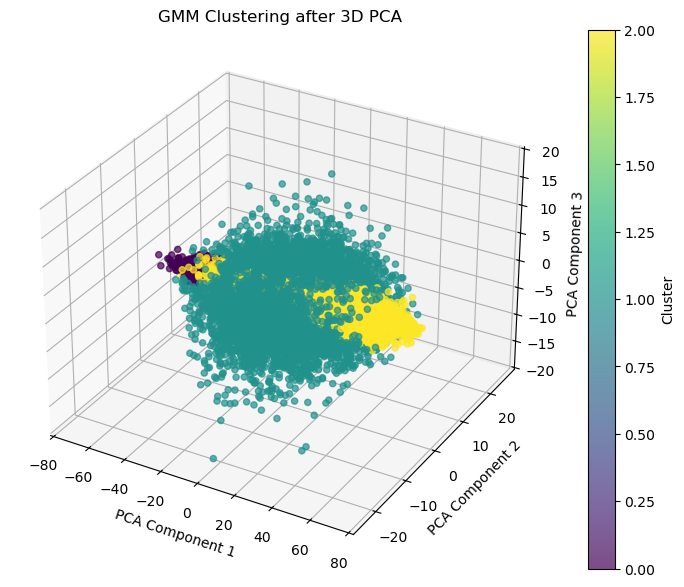

Silhouette Score: 0.1368
Calinski-Harabasz Index: 19227.9732
Dunn Index: 0.0003


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# -----------------------
# Dunn Index Function
# -----------------------
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    min_intercluster = np.inf
    max_intracluster = 0

    for i in unique_clusters:
        cluster_i = X[labels == i]
        for j in unique_clusters:
            if i != j:
                cluster_j = X[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    inter_dist = np.min(cdist(cluster_i, cluster_j))
                    min_intercluster = min(min_intercluster, inter_dist)

        if len(cluster_i) > 1:
            intra_dist = np.max(cdist(cluster_i, cluster_i))
            max_intracluster = max(max_intracluster, intra_dist)

    if max_intracluster == 0:
        return np.nan
    return min_intercluster / max_intracluster

# -----------------------
# Load & Preprocess Data
# -----------------------
data = pd.read_csv("/Users/jk/Downloads/cleaned_normalized_gse108474_data.csv")
data_numeric = data.select_dtypes(include=['number'])

imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_numeric)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

data_scaled = np.nan_to_num(data_scaled)

# -----------------------
# PCA (3D) and GMM Clustering
# -----------------------
if np.var(data_scaled) > 0:
    pca_3d = PCA(n_components=3)
    data_pca_3d = pca_3d.fit_transform(data_scaled)
else:
    raise ValueError("Data has zero variance, PCA cannot be applied.")

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(data_pca_3d)
labels = gmm.predict(data_pca_3d)

# -----------------------
# Plot 3D Clusters
# -----------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2],
                     c=labels, cmap='viridis', alpha=0.7)

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("GMM Clustering after 3D PCA")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

# -----------------------
# Calculate Clustering Metrics
# -----------------------
silhouette = silhouette_score(data_pca_3d, labels)
calinski = calinski_harabasz_score(data_pca_3d, labels)
dunn = dunn_index(data_pca_3d, labels)

# Print metrics
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")
print(f"Dunn Index: {dunn:.4f}")


In [2]:
# Step 1: Import libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Step 2: Load the dataset
data_108474 = pd.read_csv("/Users/jk/Downloads/cleaned_normalized_gse108474_data.csv")

# Step 3: Separate ID and expression data
ids = data_108474 ['id']
expression_data = data_108474 .drop(columns=['id'])

# Step 4: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(expression_data)

# Step 5: Get centroids
centroids = kmeans.cluster_centers_

# Step 6: Find closest data point (gene) to each centroid
closest_indices, distances = pairwise_distances_argmin_min(centroids, expression_data)

# Step 7: Get the corresponding gene IDs and distances
centroid_genes = pd.DataFrame({
    'cluster': range(3),
    'closest_gene_id': ids.iloc[closest_indices].values,
    'distance_to_centroid': distances
})

# Step 8: Save to Excel
excel_path = "kmeans_Genes_k3.xlsx"
centroid_genes.to_excel(excel_path, index=False)

# Display
centroid_genes


,cluster,closest_gene_id,distance_to_centroid
0,0,1569219_at,1.161718
1,1,236255_at,2.358323
2,2,218007_s_at,1.341136


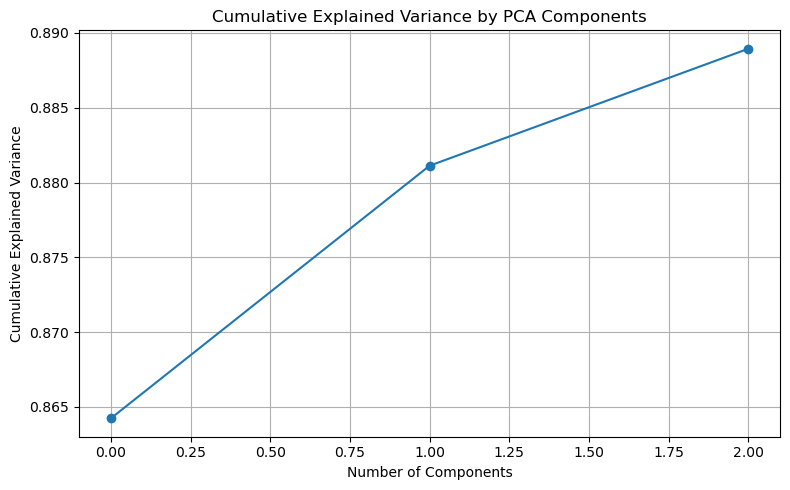

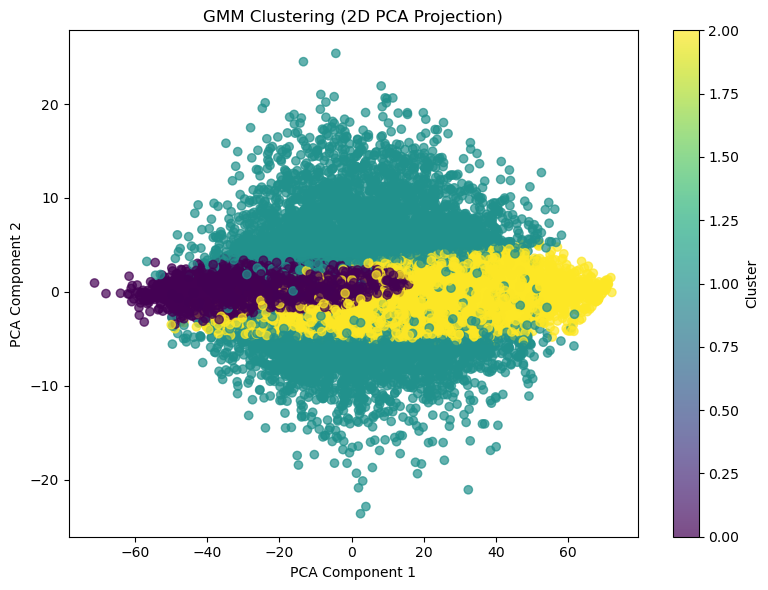

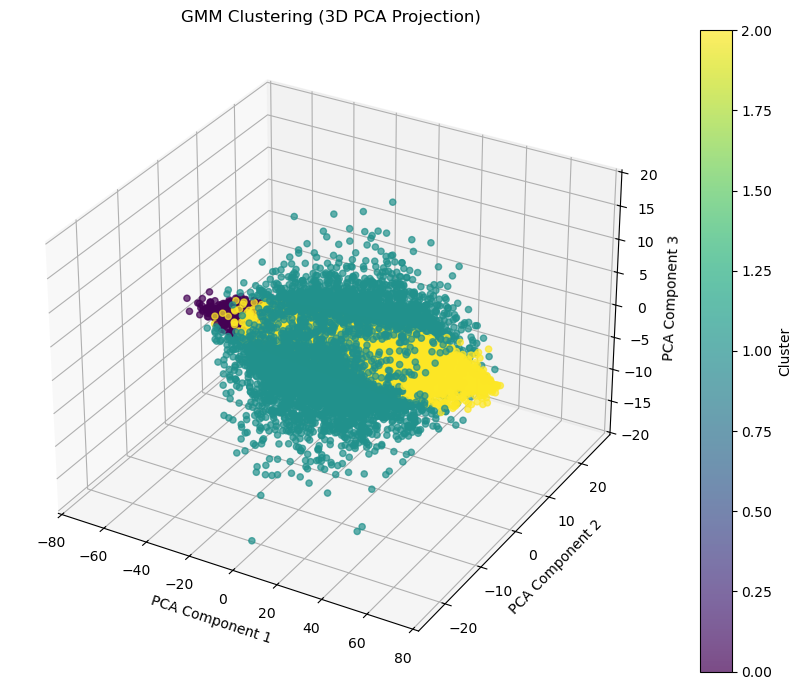

Silhouette Score: 0.1269
Calinski-Harabasz Index: 19427.2658
Dunn Index: 0.0000


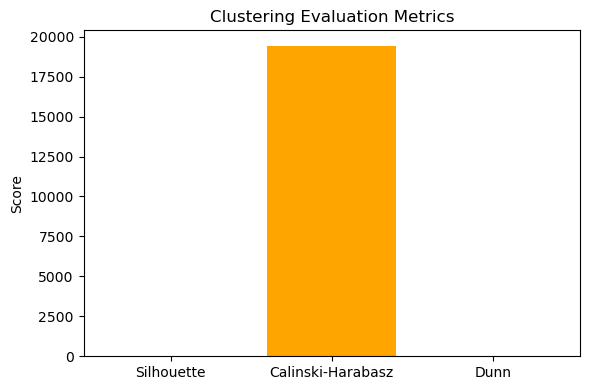

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# -----------------------
# Dunn Index Function
# -----------------------
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    min_intercluster = np.inf
    max_intracluster = 0

    for i in unique_clusters:
        cluster_i = X[labels == i]
        for j in unique_clusters:
            if i != j:
                cluster_j = X[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    inter_dist = np.min(cdist(cluster_i, cluster_j))
                    min_intercluster = min(min_intercluster, inter_dist)

        if len(cluster_i) > 1:
            intra_dist = np.max(cdist(cluster_i, cluster_i))
            max_intracluster = max(max_intracluster, intra_dist)

    if max_intracluster == 0:
        return np.nan
    return min_intercluster / max_intracluster

# -----------------------
# Load & Preprocess Data
# -----------------------
data = pd.read_csv("/Users/jk/Downloads/cleaned_normalized_gse108474_data.csv")
data_numeric = data.select_dtypes(include=['number'])

imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_numeric)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)
data_scaled = np.nan_to_num(data_scaled)

# -----------------------
# PCA and GMM Clustering
# -----------------------
if np.var(data_scaled) > 0:
    pca = PCA(n_components=3)
    data_pca = pca.fit_transform(data_scaled)
else:
    raise ValueError("Data has zero variance, PCA cannot be applied.")

# GMM Clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(data_pca)
labels = gmm.predict(data_pca)

# -----------------------
# Plot Explained Variance
# -----------------------
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 2D Plot (First 2 PCA Components)
# -----------------------
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clustering (2D PCA Projection)")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

# -----------------------
# 3D Plot (First 3 PCA Components)
# -----------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2],
                     c=labels, cmap='viridis', alpha=0.7)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("GMM Clustering (3D PCA Projection)")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.tight_layout()
plt.show()

# -----------------------
# Calculate Clustering Metrics
# -----------------------
silhouette = silhouette_score(data_pca[:, :2], labels)
calinski = calinski_harabasz_score(data_pca[:, :2], labels)
dunn = dunn_index(data_pca[:, :2], labels)

# Print metrics
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")
print(f"Dunn Index: {dunn:.4f}")

# -----------------------
# Plot Clustering Metrics
# -----------------------
plt.figure(figsize=(6, 4))
metrics_names = ['Silhouette', 'Calinski-Harabasz', 'Dunn']
metrics_values = [silhouette, calinski, dunn]
plt.bar(metrics_names, metrics_values, color=['skyblue', 'orange', 'green'])
plt.title("Clustering Evaluation Metrics")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


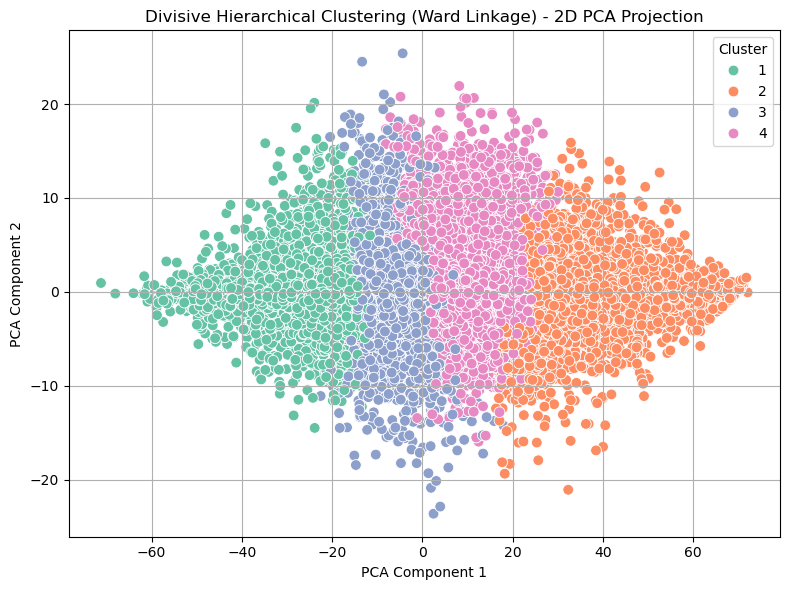

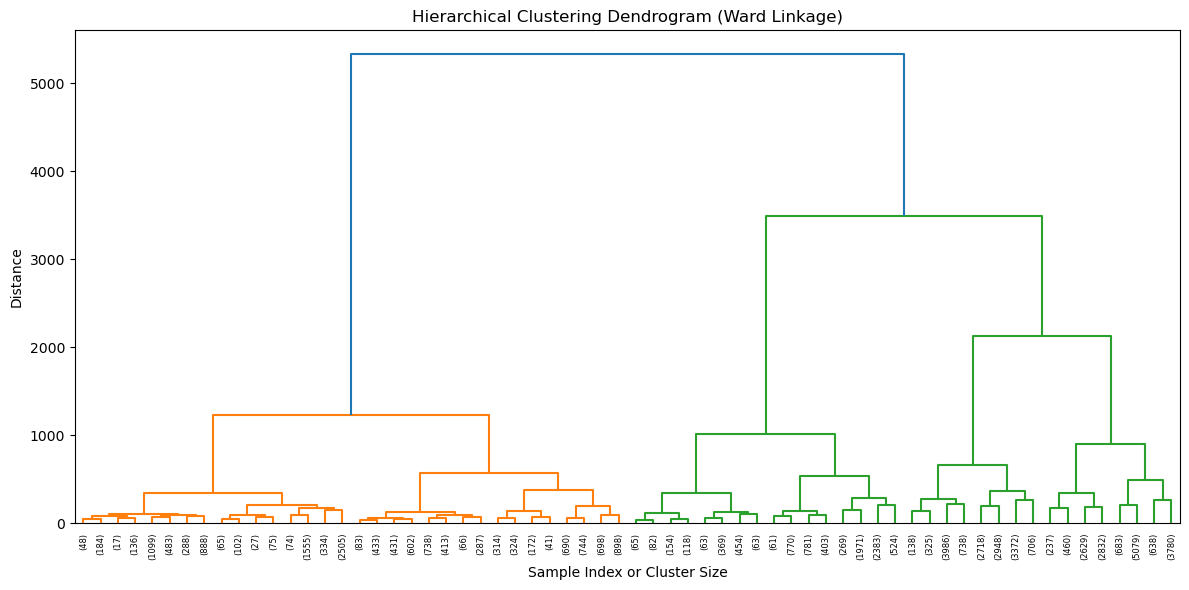

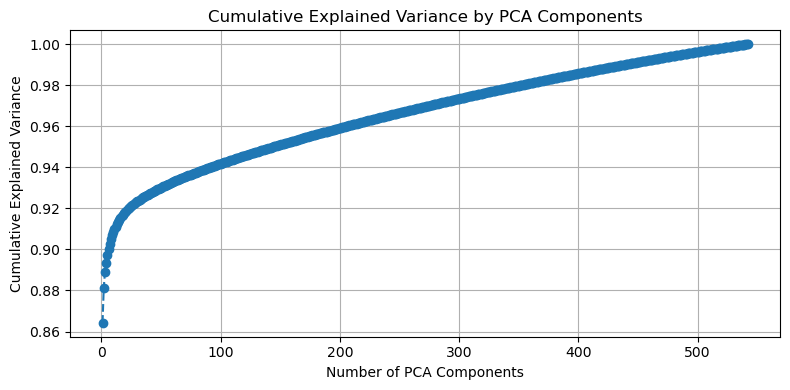

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# -----------------------
# Load and Prepare Data
# -----------------------
file_path = "/Users/jk/Downloads/cleaned_normalized_gse108474_data.csv"
df = pd.read_csv(file_path)

# Select numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# -----------------------
# Hierarchical Clustering
# -----------------------
Z = linkage(X_scaled, method='ward')  # Agglomerative, but simulates divisive visually

num_clusters = 4
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
df['Cluster'] = cluster_labels

# -----------------------
# PCA for 2D Visualization
# -----------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# -----------------------
# Scatter Plot (PCA 2D)
# -----------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='Set2', s=60)
plt.title("Divisive Hierarchical Clustering (Ward Linkage) - 2D PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# Dendrogram
# -----------------------
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5, color_threshold=None)
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.xlabel("Sample Index or Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# -----------------------
# Optional: Explained Variance Plot
# -----------------------
pca_full = PCA().fit(X_scaled)
explained_var_ratio = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_var_ratio)+1), explained_var_ratio, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score

# Compute Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X_scaled, cluster_labels)

# Compute Silhouette Score
sil_score = silhouette_score(X_scaled, cluster_labels)

print(f"Calinski-Harabasz Index: {ch_score:.2f}")
print(f"Silhouette Score: {sil_score:.4f}")

from scipy.spatial.distance import pdist, cdist

def dunn_index(X, labels):
    unique_cluster_labels = np.unique(labels)
    clusters = [X[labels == label] for label in unique_cluster_labels]

    # Compute inter-cluster distances (minimum distance between clusters)
    min_intercluster = np.inf
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = cdist(clusters[i], clusters[j], metric='euclidean')
            min_dist = np.min(dist)
            if min_dist < min_intercluster:
                min_intercluster = min_dist

    # Compute intra-cluster distances (maximum distance within a cluster)
    max_intracluster = 0
    for cluster in clusters:
        if len(cluster) > 1:
            intra_dists = pdist(cluster)
            max_dist = np.max(intra_dists)
            if max_dist > max_intracluster:
                max_intracluster = max_dist

    dunn = min_intercluster / max_intracluster if max_intracluster > 0 else np.nan
    return dunn


dunn = dunn_index(X_scaled, cluster_labels)
print(f"Dunn Index: {dunn:.4f}")


Calinski-Harabasz Index: 58362.58
Silhouette Score: 0.2794
Dunn Index: 0.0429
